<a href="https://colab.research.google.com/github/ishara-bangkit-capstone-project/ishara-machine-learning/blob/main/alternatif_2model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Data from Kaggle to further processing it

In [ ]:
! pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d agungmrf/indonesian-sign-language-bisindo

Dataset URL: https://www.kaggle.com/datasets/agungmrf/indonesian-sign-language-bisindo
License(s): unknown
 99% 1.36G/1.36G [00:07<00:00, 225MB/s]
100% 1.36G/1.36G [00:07<00:00, 201MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Importing the necessary Library


In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
%matplotlib inline

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import matplotlib.image as mpimg
import zipfile,os

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import flatbuffers
import platform
from tensorflow_lite_support.metadata import metadata_schema_py_generated as _metadata_fb
from tensorflow_lite_support.metadata import schema_py_generated
from tensorflow_lite_support.metadata.python import metadata as _metadata
from tensorflow_lite_support.metadata.python import metadata_writers
import flatbuffers

# Exctracting the Picture Data from kaggle


In [ ]:
# Tentukan nama file ZIP dan direktori ekstraksi
local_zip = '/content/indonesian-sign-language-bisindo.zip'
extract_dir = '/content/bisindo'

# Ekstrak file ZIP
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


# Load and Transfrom Data

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [ ]:
def create_binary_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

def create_multiclass_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(26, activation='softmax')(x)  # Multiclass classification

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

def compile_model(model, binary=True):
    if binary:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

def prepare_data(data_path, target_size, batch_size, class_mode, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2
        )

    train_generator = datagen.flow_from_directory(
        data_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        data_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset='validation'
    )

    return train_generator, validation_generator

def create_metadata(model_type):
    model_meta = _metadata_fb.ModelMetadataT()
    model_meta.name = f"{model_type} Hand Detection Model"
    model_meta.description = f"A {model_type.lower()} hand detection model for identifying hand presence and sign language letters."
    model_meta.version = "v1"
    model_meta.author = "C241-PS358"

    # Create input metadata
    input_meta = _metadata_fb.TensorMetadataT()
    input_meta.name = "input_image"
    input_meta.description = (
        "Input image to be classified. The expected image is {0}x{0} RGB image."
        .format(224))
    input_meta.content = _metadata_fb.ContentT()
    input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
    input_meta.content.contentProperties.colorSpace = _metadata_fb.ColorSpaceType.RGB
    input_meta.content.contentPropertiesType = _metadata_fb.ContentProperties.ImageProperties
    input_meta.content.range = _metadata_fb.ValueRangeT()
    input_meta.content.range.min = 0
    input_meta.content.range.max = 255
    input_normalization = _metadata_fb.ProcessUnitT()
    input_normalization.optionsType = (_metadata_fb.ProcessUnitOptions.NormalizationOptions)
    input_normalization.options = _metadata_fb.NormalizationOptionsT()
    input_normalization.options.mean = [127.5]
    input_normalization.options.std = [127.5]
    input_meta.processUnits = [input_normalization]
    input_meta.stats = _metadata_fb.StatsT()
    input_meta.stats.max = [255.0]
    input_meta.stats.min = [0.0]

    # Create output metadata
    output_meta = _metadata_fb.TensorMetadataT()
    output_meta.name = "output"
    if model_type == "Binary":
        output_meta.description = "Whether the image contains a hand."
        output_meta.content = _metadata_fb.ContentT()
        output_meta.content.contentProperties = _metadata_fb.FeaturePropertiesT()
        output_meta.content.contentPropertiesType = _metadata_fb.ContentProperties.FeatureProperties
    else:
        output_meta.description = "The predicted sign language letter."
        output_meta.content = _metadata_fb.ContentT()
        output_meta.content.contentProperties = _metadata_fb.FeaturePropertiesT()
        output_meta.content.contentPropertiesType = _metadata_fb.ContentProperties.FeatureProperties
        output_stats = _metadata_fb.StatsT()
        output_stats.max = [1.0] * 26  # Modify based on your actual output range
        output_stats.min = [0.0] * 26
        output_meta.stats = output_stats
        label_file = _metadata_fb.AssociatedFileT()
        label_file.name = os.path.basename('/content/gdrive/MyDrive/Capstone - Machine Learning/ISHARA/savemodel/labels.txt')
        label_file.description = "Labels for objects that the model can recognize."
        label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
        output_meta.associatedFiles = [label_file]

    # Create subgraph metadata
    subgraph = _metadata_fb.SubGraphMetadataT()
    subgraph.inputTensorMetadata = [input_meta]
    subgraph.outputTensorMetadata = [output_meta]

    # Create model metadata
    model_meta.subgraphMetadata = [subgraph]

    b = flatbuffers.Builder(0)
    b.Finish(
        model_meta.Pack(b),
        _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    return b.Output()

def main():
    # Configurations
    binary_data_path = '/content/gdrive/MyDrive/Capstone - Machine Learning/ISHARA/binary' # Replace with the path to your binary dataset
    multiclass_data_path = '/content/bisindo/bisindo/images/train' # Replace with the path to your multiclass dataset
    target_size = (224, 224)
    batch_size = 32
    epochs = 10

    # Binary Classification Model
    print("Creating and training binary classification model...")
    binary_model = create_binary_model()
    compile_model(binary_model, binary=True)
    train_gen_binary, val_gen_binary = prepare_data(binary_data_path, target_size, batch_size, 'binary', augment=True)
    binary_model.fit(train_gen_binary, epochs=epochs, validation_data=val_gen_binary)

    # Save binary model
    binary_model.save('binary_model.h5')

    # Convert binary model to TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(binary_model)
    binary_tflite_model = converter.convert()
    with open('binary_model.tflite', 'wb') as f:
        f.write(binary_tflite_model)

    # Add metadata to binary TFLite model
    binary_metadata = create_metadata("Binary")
    populator = _metadata.MetadataPopulator.with_model_file('binary_model.tflite')
    populator.load_metadata_buffer(binary_metadata)
    populator.populate()

    print("Binary model saved and converted to TFLite with metadata.")

    # Multiclass Classification Model
    print("Creating and training multiclass classification model...")
    multiclass_model = create_multiclass_model()
    compile_model(multiclass_model, binary=False)
    train_gen_multiclass, val_gen_multiclass = prepare_data(multiclass_data_path, target_size, batch_size, 'categorical', augment=False)
    multiclass_model.fit(train_gen_multiclass, epochs=epochs, validation_data=val_gen_multiclass)

    # Save multiclass model
    multiclass_model.save('multiclass_model.h5')

    # Convert multiclass model to TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(multiclass_model)
    multiclass_tflite_model = converter.convert()
    with open('multiclass_model.tflite', 'wb') as f:
        f.write(multiclass_tflite_model)

    # Add metadata to multiclass TFLite model
    multiclass_metadata = create_metadata("Multiclass")
    populator = _metadata.MetadataPopulator.with_model_file('multiclass_model.tflite')
    populator.load_metadata_buffer(multiclass_metadata)
    populator.load_associated_files(['/content/gdrive/MyDrive/Capstone - Machine Learning/ISHARA/savemodel/labels.txt'])
    populator.populate()

    print("Multiclass model saved and converted to TFLite with metadata.")

    # Inference Phase
    def load_and_preprocess_image(image_path, target_size):
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = np.expand_dims(img, axis=0) / 255.0
        return img

    def predict_image(image_path):
        img = load_and_preprocess_image(image_path, target_size)

        # Predict using the binary model
        binary_prediction = binary_model.predict(img)
        if binary_prediction[0] < 0.5:
            print("No hand detected.")
            return "No hand detected."
        else:
            # Predict using the multiclass model
            multiclass_prediction = multiclass_model.predict(img)
            predicted_class = np.argmax(multiclass_prediction, axis=1)
            print(f"Hand detected. Predicted sign language letter: {chr(65 + predicted_class[0])}")
            return chr(65 + predicted_class[0])

if __name__ == '__main__':
    main()

Creating and training binary classification model...
Found 43 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Epoch 1/10
2/2 [==============================] - 6s 2s/step - loss: 0.6749 - accuracy: 0.4884 - val_loss: 0.0138 - val_accuracy: 1.0000
Epoch 2/10
2/2 [==============================] - 1s 366ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 1s 364ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 5.1295e-04 - val_accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 1s 783ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.2218e-04 - val_accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 1s 738ms/step - loss: 2.4599e-04 - accuracy: 1.0000 - val_loss: 3.3978e-04 - val_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 1s 375ms/step - loss: 5.9803e-05 - accuracy: 1.0000 - val_loss: 2.5323e-05 - val_accuracy: 1.0000
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Binary model saved and converted to TFLite with metadata.
Creating and training multiclass classification model...
Found 7342 images belonging to 26 classes.
Found 1827 images belonging to 26 classes.
Epoch 1/10
230/230 [==============================] - 47s 190ms/step - loss: 0.8075 - accuracy: 0.7730 - val_loss: 0.0618 - val_accuracy: 0.9858
Epoch 2/10
230/230 [==============================] - 45s 194ms/step - loss: 0.2299 - accuracy: 0.9314 - val_loss: 0.0289 - val_accuracy: 0.9929
Epoch 3/10
230/230 [==============================] - 43s 186ms/step - loss: 0.0926 - accuracy: 0.9737 - val_loss: 0.0142 - val_accuracy: 0.9962
Epoch 4/10
230/230 [==============================] - 44s 193ms/step - loss: 0.0461 - accuracy: 0.9890 - val_loss: 0.0202 - val_accuracy: 0.9956
Epoch 5/10
230/230 [==============================] - 46s 200ms/step - loss: 0.0243 - accuracy: 0.9946 - val_loss: 0.0321 - val_accuracy: 0.9945
Epoch 6/10
230/230 [==============================] - 47s 203ms/step - los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Multiclass model saved and converted to TFLite with metadata.


Saving iniB.jpg to iniB (11).jpg
Saving iniM.jpg to iniM (8).jpg
Saving iniN.jpg to iniN (8).jpg
Saving iniP.jpg to iniP (8).jpg
Saving notfound1.jpg to notfound1 (8).jpg
Saving notfound2.jpg to notfound2 (8).jpg
Saving notfound3.jpg to notfound3 (8).jpg
Saving notfound4.jpg to notfound4 (8).jpg


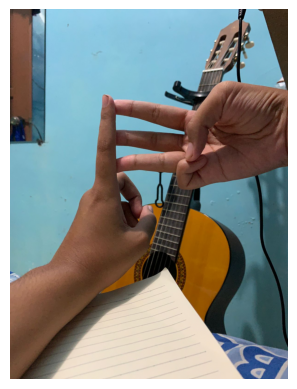

Hand detected. Predicted sign language letter: B
iniB (11).jpg: B


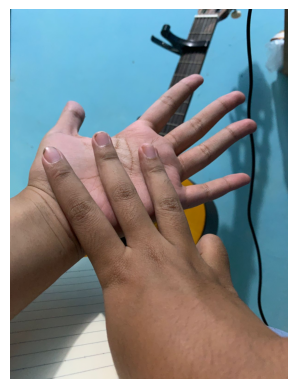

Hand detected. Predicted sign language letter: N
iniM (8).jpg: N


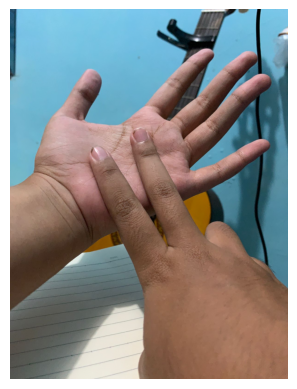

Hand detected. Predicted sign language letter: N
iniN (8).jpg: N


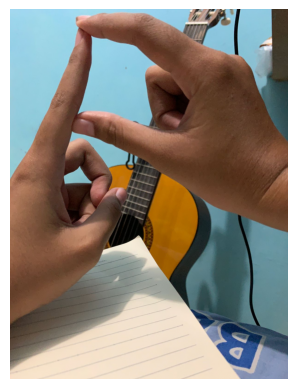

Hand detected. Predicted sign language letter: B
iniP (8).jpg: B


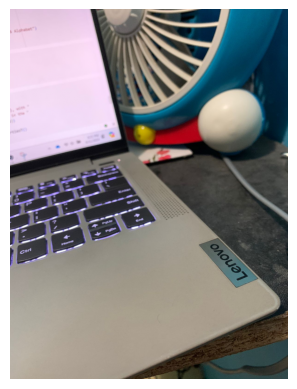

No hand detected.
notfound1 (8).jpg: No hand detected.


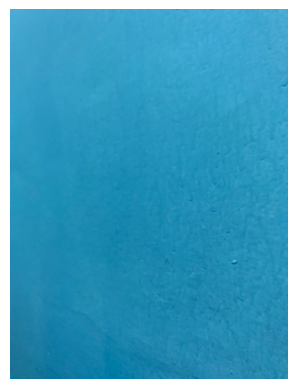

Hand detected. Predicted sign language letter: J
notfound2 (8).jpg: J


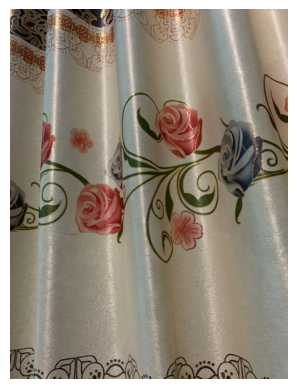

No hand detected.
notfound3 (8).jpg: No hand detected.


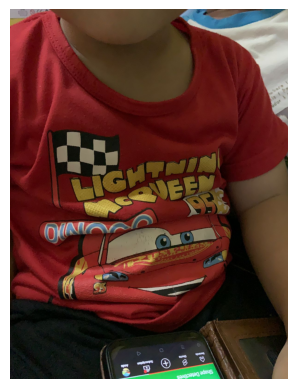

No hand detected.
notfound4 (8).jpg: No hand detected.


In [ ]:
# Inference Phase
def load_and_preprocess_image(image_path, target_size):
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0) / 255.0
  return img

def predict_image(binary_interpreter, multiclass_interpreter, image_path):
  img = load_and_preprocess_image(image_path, target_size = (224, 224))

  # Predict using the binary model
  input_details = binary_interpreter.get_input_details()
  output_details = binary_interpreter.get_output_details()
  binary_interpreter.resize_tensor_input(input_details[0]['index'], (1, 224, 224, 3))
  binary_interpreter.allocate_tensors()
  binary_interpreter.set_tensor(input_details[0]['index'], img)
  binary_interpreter.invoke()
  binary_prediction = binary_interpreter.get_tensor(output_details[0]['index'])

  if binary_prediction[0] > 0.5:
    print("No hand detected.")
    return "No hand detected."
  else:
    # Predict using the multiclass model
    input_details = multiclass_interpreter.get_input_details()
    output_details = multiclass_interpreter.get_output_details()
    multiclass_interpreter.resize_tensor_input(input_details[0]['index'], (1, 224, 224, 3))
    multiclass_interpreter.allocate_tensors()
    multiclass_interpreter.set_tensor(input_details[0]['index'], img)
    multiclass_interpreter.invoke()
    multiclass_prediction = multiclass_interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(multiclass_prediction, axis=1)
    print(f"Hand detected. Predicted sign language letter: {chr(65 + predicted_class[0])}")
    return chr(65 + predicted_class[0])

# Load TFLite models
binary_interpreter = tf.lite.Interpreter(model_path='binary_model.tflite')
binary_interpreter.allocate_tensors()
multiclass_interpreter = tf.lite.Interpreter(model_path='multiclass_model.tflite')
multiclass_interpreter.allocate_tensors()

# Upload and predict images
uploaded = files.upload()
for fn in uploaded.keys():
  plt.figure()
  plt.imshow(plt.imread(fn) / 255.)
  plt.axis("off")
  plt.show()

  result = predict_image(binary_interpreter, multiclass_interpreter, fn)
  print(f"{fn}: {result}")


Saving 1_I.jpg to 1_I.jpg
Saving 2_S.jpg to 2_S.jpg
Saving 3_H.jpg to 3_H.jpg
Saving 4_A.jpg to 4_A.jpg
Saving 5_R.jpg to 5_R.jpg
Saving 6_A.jpg to 6_A.jpg


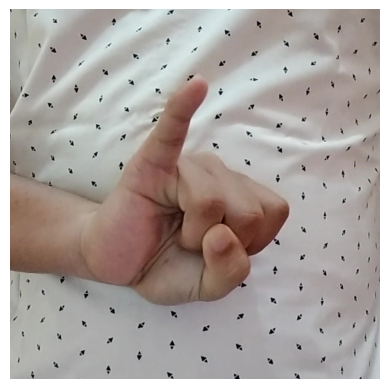

Hand detected. Predicted sign language letter: I
1_I.jpg: I


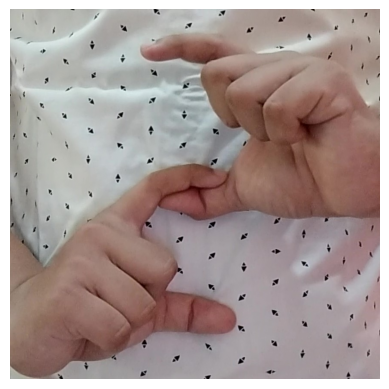

Hand detected. Predicted sign language letter: S
2_S.jpg: S


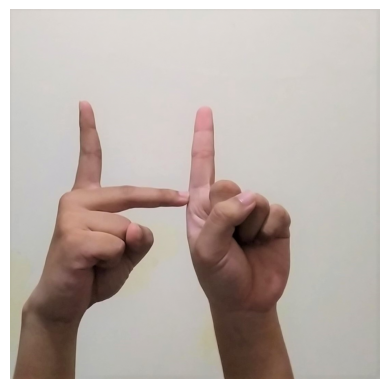

Hand detected. Predicted sign language letter: H
3_H.jpg: H


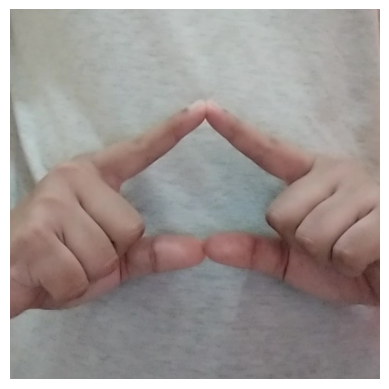

Hand detected. Predicted sign language letter: A
4_A.jpg: A


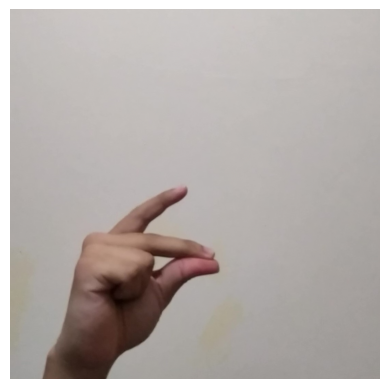

Hand detected. Predicted sign language letter: R
5_R.jpg: R


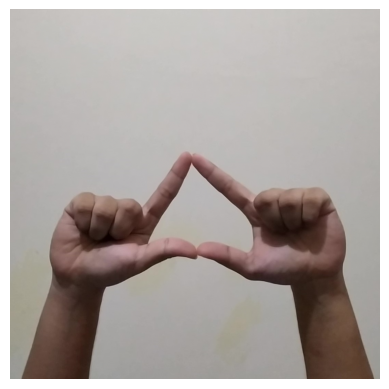

Hand detected. Predicted sign language letter: A
6_A.jpg: A


In [ ]:
# Upload and predict images
uploaded = files.upload()
for fn in uploaded.keys():
  plt.figure()
  plt.imshow(plt.imread(fn) / 255.)
  plt.axis("off")
  plt.show()

  result = predict_image(binary_interpreter, multiclass_interpreter, fn)
  print(f"{fn}: {result}")


Saving seattle_9368342_2.jpg to seattle_9368342_2.jpg


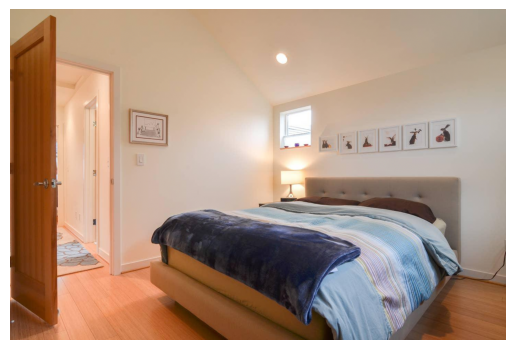

No hand detected.
seattle_9368342_2.jpg: No hand detected.


In [ ]:
# Upload and predict images
uploaded = files.upload()
for fn in uploaded.keys():
  plt.figure()
  plt.imshow(plt.imread(fn) / 255.)
  plt.axis("off")
  plt.show()

  result = predict_image(binary_interpreter, multiclass_interpreter, fn)
  print(f"{fn}: {result}")


Saving 88.png to 88.png


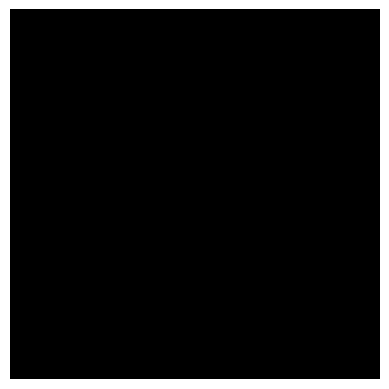

No hand detected.
88.png: No hand detected.


In [ ]:
# Upload and predict images
uploaded = files.upload()
for fn in uploaded.keys():
  plt.figure()
  plt.imshow(plt.imread(fn) / 255.)
  plt.axis("off")
  plt.show()

  result = predict_image(binary_interpreter, multiclass_interpreter, fn)
  print(f"{fn}: {result}")
